# Chapter 4: Simulation on Normal Populations


# Part I Load CNN models

## Setup

In [1]:
!pip install pyyaml h5py  # Required to save models in HDF5 format

In [2]:
import numpy as np
from scipy import stats   #ttest


# Import tensorFlow / Keras
import tensorflow as tf
from tensorflow import keras

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
# Recreate the exact same model, including its weights and the optimizer
model_CNN_m50_N20 = keras.models.load_model('/content/gdrive/MyDrive/Application_CNNs_MHT_code/Chapter4_CNN_models/my_model_Normal_m50_N20.h5')

# Show the model architecture
model_CNN_m50_N20.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 50, 50, 2)         10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 25, 25, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 1250)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               625500    
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                1

In [5]:
# Recreate the exact same model, including its weights and the optimizer
model_CNN_m100_N20 = keras.models.load_model('/content/gdrive/MyDrive/Application_CNNs_MHT_code/Chapter4_CNN_models/my_model_Normal_m100_N20.h5')

# Show the model architecture
model_CNN_m100_N20.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 2)       10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 5000)              0         
_________________________________________________________________
dense (Dense)                (None, 500)               2500500   
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2

In [6]:
# Recreate the exact same model, including its weights and the optimizer
model_CNN_m150_N20 = keras.models.load_model('/content/gdrive/MyDrive/Application_CNNs_MHT_code/Chapter4_CNN_models/my_model_Normal_m150_N20.h5')

# Show the model architecture
model_CNN_m150_N20.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 150, 150, 2)       10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 75, 75, 2)         0         
_________________________________________________________________
flatten (Flatten)            (None, 11250)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               5625500   
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               3

In [ ]:
# Recreate the exact same model, including its weights and the optimizer
#model_CNN_m200_N20 = keras.models.load_model('/content/gdrive/MyDrive/Application_CNNs_MHT_code/Chapter4_CNN_models/my_model_Normal_m200_N20.h5')

# Show the model architecture
#model_CNN_m200_N20.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 200, 200, 2)       10        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 100, 100, 2)       0         
_________________________________________________________________
flatten (Flatten)            (None, 20000)             0         
_________________________________________________________________
dense (Dense)                (None, 500)               10000500  
_________________________________________________________________
dense_1 (Dense)              (None, 250)               125250    
_________________________________________________________________
dropout (Dropout)            (None, 250)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               5

# Part II: Model Comparison: CNN vs BH

## Setup

In [7]:
import numpy as np
from scipy import stats   #ttest
from sklearn.metrics import confusion_matrix, roc_curve, auc


%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

## Functions

* `Normal_Population_Simulation`
* `BH_Significant_values`
* `DL_Significant_values`
* `performance_normal_pop_BH_vs_CNN`
* `Benchmark_Normal_population`


In [8]:
# 2) Function:`
def Normal_Population_Simulation(B = 2,
                                 m = 10,
                                 p0 = 0.9,
                                 N = 2,
                                 mu_A = 2,
                                 seed = 42,
                                 reduced = True):
  '''
  Simulation of Normal populations:

  1) Inputs:
  -----------

  2) Outputs:
  -----------

  '''
  
  # Control population: All mean 0
  np.random.seed(seed)
  control = np.random.normal(loc = 0.0, scale=1.0, size = (B,m,N))

  m0 = np.int16(np.floor(m*p0))  # Number of test where null hypothesis is true (s)
  m1 = np.int16(m-m0)            # Number of test where null hypothesis is false (saved like int)
  null_Hypothesis = np.repeat(0,m)
  mx = np.repeat(0,m)
  null_Hypothesis[0:m1] = 1
  mx[0:m1] = mu_A

  v_mx = np.array([])
  # Alternative population
  for i in range(B):
    v_mx = np.append(v_mx, np.repeat(mx, N))

  np.random.seed(seed + 1)
  alternative_pop = np.random.normal(loc = v_mx, scale = 1.0).reshape(B,m,N)

  set_pvalues = np.zeros(shape = (B, m))
  set_o_index = np.zeros(shape = (B, m))
  set_Null_H  = np.zeros(shape = (B, m))
  set_lbbf    = np.zeros(shape = (B, m))
  set_images  = np.zeros(shape = (B, m, m))

  div_lbbf = lambda t: lbbf[t]/lbbf

  for index in range(B):
    # Original distribution null_hypothesis
    code_nullHypothesis = null_Hypothesis.copy()
    
    p_values = np.array([result[1] for result in list(map(stats.ttest_ind, control[index,:,:], alternative_pop[index,:,:]))])
    o = np.argsort(p_values)
    set_o_index[index,:] = o
    # Order p-values and code_nullHypothesis
    p_values = p_values[o]
    set_pvalues[index,:] = p_values
    code_nullHypothesis  = code_nullHypothesis[o]
    set_Null_H[index, :] = code_nullHypothesis
    
    # LBBF
    lbbf = np.where(p_values < (1/np.exp(1)), -np.exp(1)*p_values*np.log(p_values), 1)
    set_lbbf[index,:] = lbbf

    # Image
    image_lbbf = np.array([div_lbbf(xi) for xi in np.arange(0,m)]).T

    # We compute the maximum lbf quotient, in order to standarize the matrix in the range 0 and 1
    max_lbbf = np.max(image_lbbf)

    # Input of the ANNs - CNNs
    set_images[index,:,:] = image_lbbf/max_lbbf
    #End for index in range(B):

  # otuput of the function
  if reduced is True:
    #Only X, Y and p-values
    output_dict = {'X': set_images,  'Y': set_Null_H, 
                  'p_value': set_pvalues}
  else:
    # Add LBBF, index, mu_A and p0
    output_dict = {'X': set_images,  'Y': set_Null_H, 
                  'p_value': set_pvalues,  'LBBF':  set_lbbf, 
                  'index': set_o_index,
                  'mu_A': mu_A, 'p0': p0, 'N':N }

  return output_dict

In [9]:
def BH_Significant_values(v_grid,
                           a_pvalues,
                           a_nullHypothesis,
                           n_m,
                           n_sim = 1):
  '''
  Function that computes the performance under several models:

  Input
  -----



  Output
  -----

  roc_values: FPR and TPR
  prec_recall: Precision and recall
  counts: R, fp, tp, fn, tn, type-II error  
  '''

  # Ravel the vectors of v_pvalues and v_nullHypothesis

  v_pvalues = a_pvalues.ravel()
  v_nullHypothesis = a_nullHypothesis.ravel()
 
  #----------------------------------------------------
  # Benjamini Hocheberg FDR
  
  roc_values_BH = [[0,0]]
  prec_recall_BH = [[0,1]]
  counts_BH = [[0,0,0,np.sum(v_nullHypothesis),len(v_nullHypothesis) - np.sum(v_nullHypothesis),1]]
  for _q in v_grid:
    BH_bound = np.arange(1,n_m+1)*(_q)/n_m
    BH_bound = np.tile(BH_bound,n_sim)
    call_BH_q = np.where(v_pvalues < BH_bound, False, True)
    code_call_BH_q = np.logical_not(call_BH_q).astype(int)
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, code_call_BH_q).ravel()
    R = fp + tp
    fpr = fp/(fp + tn)
    tpr = tp/(tp+fn)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_BH.append([fpr, tpr])
    prec_recall_BH.append([tpr, prec])
    counts_BH.append([R, fp, tp, fn, tn, fnr])
    # End for

  # Outout_dict
  output_dict = {'roc_values_BH': roc_values_BH, 'prec_recall_BH': prec_recall_BH, 'counts_BH' : counts_BH}

  return output_dict

In [10]:
def DL_Significant_values(v_grid, a_test, a_score):

  '''
  Function that computes the performance under several models:

  Input
  -----



  Output
  -----

  roc_values: FPR and TPR
  prec_recall: Precision and recall
  counts: R, fp, tp, fn, tn, type-II error  
  '''

  y_fpr, _, thresholds = roc_curve(a_test.ravel(), a_score.ravel())
   
  roc_values_DL = [[0,0]]
  prec_recall_DL = [[0,1]]
  v_nullHypothesis = a_test.ravel()
  counts_DL = [[0, 0, 0, np.sum(v_nullHypothesis),len(v_nullHypothesis) - np.sum(v_nullHypothesis), 1]]
  for tt in v_grid:

    # Create copy of the thresholds and fpr objects
    max_thr_fpr = thresholds[len(y_fpr[y_fpr <= tt]) - 1]
    y_hat = np.where(a_score >= max_thr_fpr, 1,0)
    
    tn, fp, fn, tp = confusion_matrix(v_nullHypothesis, y_hat.ravel()).ravel()
    R = fp + tp
    fpr = fp/(fp + tn)
    tpr = tp/(tp+fn)
    if fp == 0:
      prec = 1
    else:
      prec = tp/(tp + fp)
    # Type-II error
    fnr = fn/(fn + tp)
    roc_values_DL.append([fpr, tpr])
    prec_recall_DL.append([tpr, prec])
    counts_DL.append([R, fp, tp, fn, tn, fnr])
    # End for

  # Outout_dict
  output_dict = {'roc_values_DL': roc_values_DL, 'prec_recall_DL': prec_recall_DL, 'counts_DL' : counts_DL}

  return output_dict

In [11]:

def performance_normal_pop_BH_vs_CNN(B_bench,
                                     N_bench,
                                     m_bench,
                                     p0_bench,
                                     v_grid,
                                     model_CNN,
                                     seed = 42):

  '''
  Comparison of BH vs DL methods, considering the following means: 0.5, 1 and 2

  1) Input

  2) Output
  
  
  '''

  ext_grid = np.append(0, v_grid)

  # -----------------------
  # mu_A = 0.5
  # -----------------------

  mu_A05 = Normal_Population_Simulation(B = B_bench,
                                        N = N_bench,
                                        m = m_bench,
                                        p0 = p0_bench,
                                        mu_A = 0.5,
                                        seed = seed)
  X_mu_A05 = mu_A05['X']
  Y_mu_A05 = mu_A05['Y']
  p_mu_A05 = mu_A05['p_value']

  # Evaluate into the CNN
  X_mu_A05_CNN = X_mu_A05.copy()
  X_mu_A05_CNN = X_mu_A05_CNN[..., np.newaxis]

  # Model predictions
  y_score_mu_A05 = model_CNN.predict(X_mu_A05_CNN)

  # Performance UHT, BFC and BHC
  out_sig_grid_mu_A05 = BH_Significant_values(v_grid = v_grid,
                                              a_pvalues = p_mu_A05,
                                              a_nullHypothesis = Y_mu_A05,
                                              n_m = m_bench,
                                              n_sim = B_bench)

  # Performance ANN for several significant values
  out_DL_mu_A05 = DL_Significant_values(v_grid = v_grid,
                                        a_test = Y_mu_A05,
                                        a_score = y_score_mu_A05)

  # BH
  rej_BH_mu_A05, _, _, _,_,_        = zip(*out_sig_grid_mu_A05['counts_BH'])
  fpr_BH_mu_A05, tpr_BH_mu_A05      = zip(*out_sig_grid_mu_A05['roc_values_BH'])
  recall_BH_mu_A05 , prec_BH_mu_A05 = zip(*out_sig_grid_mu_A05['prec_recall_BH'])

  # 3) DL results
  rej_DL_mu_A05, _, _, _,_,_       = zip(*out_DL_mu_A05['counts_DL'])
  fpr_DL_mu_A05, tpr_DL_mu_A05     = zip(*out_DL_mu_A05['roc_values_DL'])
  recall_DL_mu_A05, prec_DL_mu_A05 = zip(*out_DL_mu_A05['prec_recall_DL'])

  dict_mu_A05_BH = {'rej_BH_mu_A05': rej_BH_mu_A05, 
                    'fpr_BH_mu_A05': fpr_BH_mu_A05, 'tpr_BH_mu_A05': tpr_BH_mu_A05,
                    'recall_BH_mu_A05': recall_BH_mu_A05, 'prec_BH_mu_A05': prec_BH_mu_A05}

  dict_mu_A05_DL = {'rej_DL_mu_A05': rej_DL_mu_A05, 
                    'fpr_DL_mu_A05': fpr_DL_mu_A05, 'tpr_DL_mu_A05': tpr_DL_mu_A05,
                    'recall_DL_mu_A05': recall_DL_mu_A05, 'prec_DL_mu_A05': prec_DL_mu_A05}

  # -----------------------
  # mu_A = 1
  # -----------------------

  mu_A1 = Normal_Population_Simulation(B = B_bench,
                                       N = N_bench,
                                       m = m_bench,
                                       p0 = p0_bench,
                                       mu_A = 1,
                                       seed = seed)
  X_mu_A1 = mu_A1['X']
  Y_mu_A1 = mu_A1['Y']
  p_mu_A1 = mu_A1['p_value']

  # Evaluate into the CNN
  X_mu_A1_CNN = X_mu_A1.copy()
  X_mu_A1_CNN = X_mu_A1_CNN[..., np.newaxis]

  # Model predictions
  y_score_mu_A1 = model_CNN.predict(X_mu_A1_CNN)

  # Performance UHT, BFC and BHC
  out_sig_grid_mu_A1 = BH_Significant_values(v_grid = v_grid,
                                             a_pvalues = p_mu_A1,
                                             a_nullHypothesis = Y_mu_A1,
                                             n_m = m_bench,
                                             n_sim = B_bench)

  # Performance ANN for several significant values
  out_DL_mu_A1 = DL_Significant_values(v_grid = v_grid,
                                       a_test = Y_mu_A1,
                                       a_score = y_score_mu_A1)

  # BH
  rej_BH_mu_A1, _, _, _,_,_       = zip(*out_sig_grid_mu_A1['counts_BH'])
  fpr_BH_mu_A1, tpr_BH_mu_A1      = zip(*out_sig_grid_mu_A1['roc_values_BH'])
  recall_BH_mu_A1 , prec_BH_mu_A1 = zip(*out_sig_grid_mu_A1['prec_recall_BH'])

  # 3) DL results
  rej_DL_mu_A1, _, _, _,_,_      = zip(*out_DL_mu_A1['counts_DL'])
  fpr_DL_mu_A1, tpr_DL_mu_A1     = zip(*out_DL_mu_A1['roc_values_DL'])
  recall_DL_mu_A1, prec_DL_mu_A1 = zip(*out_DL_mu_A1['prec_recall_DL'])

  dict_mu_A1_BH = {'rej_BH_mu_A1': rej_BH_mu_A1, 
                   'fpr_BH_mu_A1': fpr_BH_mu_A1, 'tpr_BH_mu_A1': tpr_BH_mu_A1,
                   'recall_BH_mu_A1': recall_BH_mu_A1, 'prec_BH_mu_A1': prec_BH_mu_A1}

  dict_mu_A1_DL = {'rej_DL_mu_A1': rej_DL_mu_A1, 
                   'fpr_DL_mu_A1': fpr_DL_mu_A1, 'tpr_DL_mu_A1': tpr_DL_mu_A1,
                   'recall_DL_mu_A1': recall_DL_mu_A1, 'prec_DL_mu_A1': prec_DL_mu_A1}

  # -----------------------
  # mu_A = 2
  # -----------------------

  mu_A2 = Normal_Population_Simulation(B = B_bench,
                                       N = N_bench,
                                       m = m_bench,
                                       p0 = p0_bench,
                                       mu_A = 2,
                                       seed = seed)
  X_mu_A2 = mu_A2['X']
  Y_mu_A2 = mu_A2['Y']
  p_mu_A2 = mu_A2['p_value']

  # Evaluate into the CNN
  X_mu_A2_CNN = X_mu_A2.copy()
  X_mu_A2_CNN = X_mu_A2_CNN[..., np.newaxis]

  # Model predictions
  y_score_mu_A2 = model_CNN.predict(X_mu_A2_CNN)

  # Performance UHT, BFC and BHC
  out_sig_grid_mu_A2 = BH_Significant_values(v_grid = v_grid,
                                             a_pvalues = p_mu_A2,
                                             a_nullHypothesis = Y_mu_A2,
                                             n_m = m_bench,
                                             n_sim = B_bench)

  # Performance ANN for several significant values
  out_DL_mu_A2 = DL_Significant_values(v_grid = v_grid,
                                       a_test = Y_mu_A2,
                                       a_score = y_score_mu_A2)

  # BH
  rej_BH_mu_A2, _, _, _,_,_       = zip(*out_sig_grid_mu_A2['counts_BH'])
  fpr_BH_mu_A2, tpr_BH_mu_A2      = zip(*out_sig_grid_mu_A2['roc_values_BH'])
  recall_BH_mu_A2 , prec_BH_mu_A2 = zip(*out_sig_grid_mu_A2['prec_recall_BH'])

  # 3) DL results
  rej_DL_mu_A2, _, _, _,_,_      = zip(*out_DL_mu_A2['counts_DL'])
  fpr_DL_mu_A2, tpr_DL_mu_A2     = zip(*out_DL_mu_A2['roc_values_DL'])
  recall_DL_mu_A2, prec_DL_mu_A2 = zip(*out_DL_mu_A2['prec_recall_DL'])

  dict_mu_A2_BH = {'rej_BH_mu_A2': rej_BH_mu_A2, 
                   'fpr_BH_mu_A2': fpr_BH_mu_A2, 'tpr_BH_mu_A2': tpr_BH_mu_A2,
                   'recall_BH_mu_A2': recall_BH_mu_A2, 'prec_BH_mu_A2': prec_BH_mu_A2}

  dict_mu_A2_DL = {'rej_DL_mu_A2': rej_DL_mu_A2, 
                   'fpr_DL_mu_A2': fpr_DL_mu_A2, 'tpr_DL_mu_A2': tpr_DL_mu_A2,
                   'recall_DL_mu_A2': recall_DL_mu_A2, 'prec_DL_mu_A2': prec_DL_mu_A2}


  output_dic = {'dict_mu_A05_BH': dict_mu_A05_BH, 'dict_mu_A05_DL': dict_mu_A05_DL,
                'dict_mu_A1_BH': dict_mu_A1_BH, 'dict_mu_A1_DL': dict_mu_A1_DL,
                'dict_mu_A2_BH': dict_mu_A2_BH, 'dict_mu_A2_DL': dict_mu_A2_DL,
                'ext_grid': ext_grid, 'Y_mu_A': Y_mu_A05}

  return output_dic

In [12]:
def Benchmark_Normal_population(m_bench,
                                N_bench,
                                B_bench,
                                v_grid,
                                model_CNN,
                                seed = 42):
  '''
  Compute the Benchamrk of BH and DL

  1) Input:

  2) Output:
  
  '''

  # Proportion true Null Hypothesis
  bench09 = performance_normal_pop_BH_vs_CNN(B_bench = B_bench,
                                              N_bench = N_bench,
                                              m_bench = m_bench,
                                              p0_bench = 0.9,
                                              v_grid = v_grid,
                                              model_CNN = model_CNN,
                                              seed = seed)

  bench095 = performance_normal_pop_BH_vs_CNN(B_bench = B_bench,
                                              N_bench = N_bench,
                                              m_bench = m_bench,
                                              p0_bench = 0.95,
                                              v_grid = v_grid,
                                              model_CNN = model_CNN,
                                              seed = seed)


  bench099 = performance_normal_pop_BH_vs_CNN(B_bench = B_bench,
                                              N_bench = N_bench,
                                              m_bench = m_bench,
                                              p0_bench = 0.99,
                                              v_grid = v_grid,
                                              model_CNN = model_CNN,
                                              seed = seed)
  
  bench_dict = {'bench09':bench09, 'bench095':bench095, 'bench099':bench099}
  return bench_dict

## Plot Functions

In [13]:
def plot_normal_population_BH_vs_CNN(bench09_I,
                                     bench095_I, 
                                     bench099_I,
                                     bench09_II,
                                     bench095_II, 
                                     bench099_II,
                                     bench09_III,
                                     bench095_III, 
                                     bench099_III,
                                     title = 'Precision-Recall Curve',
                                     fig_save = None):

  # -----------------------
  # Plot the figure
  # -----------------------

  fig, ((ax1, ax2, ax3), (ax4, ax5, ax6), (ax7, ax8, ax9))  = plt.subplots(nrows=3, ncols=3, figsize=(15,14))
  #fig, (ax1, ax2, ax3)  = plt.subplots(nrows=1, ncols=3, figsize=(15,14))
  # -----------------------
  #   Row 1, m = 50, (ax1, ax2, ax3) = (0.9, 0.95, 0.99)
  # -----------------------

  baseline_pr = np.sum(bench09_I['Y_mu_A'].ravel())/len(bench09_I['Y_mu_A'].ravel())
  ax1.plot(bench09_I['dict_mu_A05_BH']['recall_BH_mu_A05'],bench09_I['dict_mu_A05_BH']['prec_BH_mu_A05'], ':', color='green',
           label = r'$\mu_A (0.5)  = {:.2f}$'.format(auc(bench09_I['dict_mu_A05_BH']['recall_BH_mu_A05'],bench09_I['dict_mu_A05_BH']['prec_BH_mu_A05'])))
  ax1.plot(bench09_I['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench09_I['dict_mu_A1_BH']['prec_BH_mu_A1'],  '--', color='green',
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench09_I['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench09_I['dict_mu_A1_BH']['prec_BH_mu_A1'])))
  ax1.plot(bench09_I['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench09_I['dict_mu_A2_BH']['prec_BH_mu_A2'],  '-', color='green', 
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench09_I['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench09_I['dict_mu_A2_BH']['prec_BH_mu_A2'])))
  ax1.plot(bench09_I['dict_mu_A05_DL']['recall_DL_mu_A05'],bench09_I['dict_mu_A05_DL']['prec_DL_mu_A05'], ':', color='mediumblue',
           label = r'$\mu_A (0.5) = {:.2f}$'.format(auc(bench09_I['dict_mu_A05_DL']['recall_DL_mu_A05'],bench09_I['dict_mu_A05_DL']['prec_DL_mu_A05'])))
  ax1.plot(bench09_I['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench09_I['dict_mu_A1_DL']['prec_DL_mu_A1'], '--' , color='mediumblue', 
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench09_I['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench09_I['dict_mu_A1_DL']['prec_DL_mu_A1'])))
  ax1.plot(bench09_I['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench09_I['dict_mu_A2_DL']['prec_DL_mu_A2'],  '-' , color='mediumblue',
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench09_I['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench09_I['dict_mu_A2_DL']['prec_DL_mu_A2'])))
  ax1.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr), color = 'grey')
  ax1.set_title(r'Proportion true null hypothesis: $p_0 = 0.9$')
  ax1.set(xlabel='', ylabel = 'm = 50')
  ax1.set_ylim([0, 1.05])
  ax1.legend(loc = 'center left', fontsize = 'small')

  baseline_pr = np.sum(bench095_I['Y_mu_A'].ravel())/len(bench095_I['Y_mu_A'].ravel())
  ax2.plot(bench095_I['dict_mu_A05_BH']['recall_BH_mu_A05'],bench095_I['dict_mu_A05_BH']['prec_BH_mu_A05'], ':', color='green',
           label = r'$\mu_A (0.5)  = {:.2f}$'.format(auc(bench095_I['dict_mu_A05_BH']['recall_BH_mu_A05'],bench095_I['dict_mu_A05_BH']['prec_BH_mu_A05'])))
  ax2.plot(bench095_I['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench095_I['dict_mu_A1_BH']['prec_BH_mu_A1'],  '--', color='green',
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench095_I['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench095_I['dict_mu_A1_BH']['prec_BH_mu_A1'])))
  ax2.plot(bench095_I['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench095_I['dict_mu_A2_BH']['prec_BH_mu_A2'],  '-', color='green', 
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench095_I['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench095_I['dict_mu_A2_BH']['prec_BH_mu_A2'])))
  ax2.plot(bench095_I['dict_mu_A05_DL']['recall_DL_mu_A05'],bench095_I['dict_mu_A05_DL']['prec_DL_mu_A05'], ':', color='mediumblue',
           label = r'$\mu_A (0.5) = {:.2f}$'.format(auc(bench095_I['dict_mu_A05_DL']['recall_DL_mu_A05'],bench095_I['dict_mu_A05_DL']['prec_DL_mu_A05'])))
  ax2.plot(bench095_I['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench095_I['dict_mu_A1_DL']['prec_DL_mu_A1'], '--' , color='mediumblue', 
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench095_I['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench095_I['dict_mu_A1_DL']['prec_DL_mu_A1'])))
  ax2.plot(bench095_I['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench095_I['dict_mu_A2_DL']['prec_DL_mu_A2'],  '-' , color='mediumblue',
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench095_I['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench095_I['dict_mu_A2_DL']['prec_DL_mu_A2'])))
  ax2.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr), color = 'grey')
  ax2.set_title(r'Proportion true null hypothesis: $p_0 = 0.95$')
  ax2.set(xlabel='', ylabel='')
  ax2.set_ylim([0, 1.05])
  ax2.legend(loc = 'center left', fontsize = 'small')


  baseline_pr = np.sum(bench099_I['Y_mu_A'].ravel())/len(bench099_I['Y_mu_A'].ravel())
  ax3.plot(bench099_I['dict_mu_A05_BH']['recall_BH_mu_A05'],bench099_I['dict_mu_A05_BH']['prec_BH_mu_A05'], ':', color='green',
           label = r'$\mu_A (0.5)  = {:.2f}$'.format(auc(bench099_I['dict_mu_A05_BH']['recall_BH_mu_A05'],bench099_I['dict_mu_A05_BH']['prec_BH_mu_A05'])))
  ax3.plot(bench099_I['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench099_I['dict_mu_A1_BH']['prec_BH_mu_A1'],  '--', color='green',
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench099_I['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench099_I['dict_mu_A1_BH']['prec_BH_mu_A1'])))
  ax3.plot(bench099_I['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench099_I['dict_mu_A2_BH']['prec_BH_mu_A2'],  '-', color='green', 
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench099_I['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench099_I['dict_mu_A2_BH']['prec_BH_mu_A2'])))
  ax3.plot(bench099_I['dict_mu_A05_DL']['recall_DL_mu_A05'],bench099_I['dict_mu_A05_DL']['prec_DL_mu_A05'], ':', color='mediumblue',
           label = r'$\mu_A (0.5) = {:.2f}$'.format(auc(bench099_I['dict_mu_A05_DL']['recall_DL_mu_A05'],bench099_I['dict_mu_A05_DL']['prec_DL_mu_A05'])))
  ax3.plot(bench099_I['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench099_I['dict_mu_A1_DL']['prec_DL_mu_A1'], '--' , color='mediumblue', 
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench099_I['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench099_I['dict_mu_A1_DL']['prec_DL_mu_A1'])))
  ax3.plot(bench099_I['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench099_I['dict_mu_A2_DL']['prec_DL_mu_A2'],  '-' , color='mediumblue',
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench099_I['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench099_I['dict_mu_A2_DL']['prec_DL_mu_A2'])))
  ax3.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr), color = 'grey')
  ax3.set_title(r'Proportion true null hypothesis: $p_0 = 0.99$')
  ax3.set(xlabel='', ylabel='')
  ax3.set_ylim([0, 1.05])
  ax3.legend(loc = 'center left', fontsize = 'small')
  #box = ax3.get_position()
  #ax3.set_position([box.x0, box.y0, box.width * 0.8, box.height])
  #ax3.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  
  # -----------------------
  #   Row 2, m = 100, (ax4, ax5, ax6)
  # -----------------------
  baseline_pr = np.sum(bench09_II['Y_mu_A'].ravel())/len(bench09_II['Y_mu_A'].ravel())
  ax4.plot(bench09_II['dict_mu_A05_BH']['recall_BH_mu_A05'],bench09_II['dict_mu_A05_BH']['prec_BH_mu_A05'], ':', color='green',
           label = r'$\mu_A (0.5)  = {:.2f}$'.format(auc(bench09_II['dict_mu_A05_BH']['recall_BH_mu_A05'],bench09_II['dict_mu_A05_BH']['prec_BH_mu_A05'])))
  ax4.plot(bench09_II['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench09_II['dict_mu_A1_BH']['prec_BH_mu_A1'],  '--', color='green',
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench09_II['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench09_II['dict_mu_A1_BH']['prec_BH_mu_A1'])))
  ax4.plot(bench09_II['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench09_II['dict_mu_A2_BH']['prec_BH_mu_A2'],  '-', color='green', 
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench09_II['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench09_II['dict_mu_A2_BH']['prec_BH_mu_A2'])))
  ax4.plot(bench09_II['dict_mu_A05_DL']['recall_DL_mu_A05'],bench09_II['dict_mu_A05_DL']['prec_DL_mu_A05'], ':', color='mediumblue',
           label = r'$\mu_A (0.5) = {:.2f}$'.format(auc(bench09_II['dict_mu_A05_DL']['recall_DL_mu_A05'],bench09_II['dict_mu_A05_DL']['prec_DL_mu_A05'])))
  ax4.plot(bench09_II['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench09_II['dict_mu_A1_DL']['prec_DL_mu_A1'], '--' , color='mediumblue', 
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench09_II['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench09_II['dict_mu_A1_DL']['prec_DL_mu_A1'])))
  ax4.plot(bench09_II['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench09_II['dict_mu_A2_DL']['prec_DL_mu_A2'],  '-' , color='mediumblue',
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench09_II['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench09_II['dict_mu_A2_DL']['prec_DL_mu_A2'])))
  ax4.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr), color = 'grey')
  #ax4.set_title('Precision-Recall Curve')
  ax4.set(xlabel='', ylabel='m = 100')
  ax4.set_ylim([0, 1.05])
  ax4.legend(loc = 'center left', fontsize = 'small')

  baseline_pr = np.sum(bench095_II['Y_mu_A'].ravel())/len(bench095_II['Y_mu_A'].ravel())
  ax5.plot(bench095_II['dict_mu_A05_BH']['recall_BH_mu_A05'],bench095_II['dict_mu_A05_BH']['prec_BH_mu_A05'], ':', color='green',
           label = r'$\mu_A (0.5)  = {:.2f}$'.format(auc(bench095_II['dict_mu_A05_BH']['recall_BH_mu_A05'],bench095_II['dict_mu_A05_BH']['prec_BH_mu_A05'])))
  ax5.plot(bench095_II['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench095_II['dict_mu_A1_BH']['prec_BH_mu_A1'],  '--', color='green',
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench095_II['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench095_II['dict_mu_A1_BH']['prec_BH_mu_A1'])))
  ax5.plot(bench095_II['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench095_II['dict_mu_A2_BH']['prec_BH_mu_A2'],  '-', color='green', 
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench095_II['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench095_II['dict_mu_A2_BH']['prec_BH_mu_A2'])))
  ax5.plot(bench095_II['dict_mu_A05_DL']['recall_DL_mu_A05'],bench095_II['dict_mu_A05_DL']['prec_DL_mu_A05'], ':', color='mediumblue',
           label = r'$\mu_A (0.5) = {:.2f}$'.format(auc(bench095_II['dict_mu_A05_DL']['recall_DL_mu_A05'],bench095_II['dict_mu_A05_DL']['prec_DL_mu_A05'])))
  ax5.plot(bench095_II['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench095_II['dict_mu_A1_DL']['prec_DL_mu_A1'], '--' , color='mediumblue', 
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench095_II['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench095_II['dict_mu_A1_DL']['prec_DL_mu_A1'])))
  ax5.plot(bench095_II['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench095_II['dict_mu_A2_DL']['prec_DL_mu_A2'],  '-' , color='mediumblue',
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench095_II['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench095_II['dict_mu_A2_DL']['prec_DL_mu_A2'])))
  ax5.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr), color = 'grey')
  #ax5.set_title('Precision-Recall Curve')
  ax5.set(xlabel='', ylabel='')
  ax5.set_ylim([0, 1.05])
  ax5.legend(loc = 'center left', fontsize = 'small')


  baseline_pr = np.sum(bench099_II['Y_mu_A'].ravel())/len(bench099_II['Y_mu_A'].ravel())
  ax6.plot(bench099_II['dict_mu_A05_BH']['recall_BH_mu_A05'],bench099_II['dict_mu_A05_BH']['prec_BH_mu_A05'], ':', color='green',
           label = r'$\mu_A (0.5)  = {:.2f}$'.format(auc(bench099_II['dict_mu_A05_BH']['recall_BH_mu_A05'],bench099_II['dict_mu_A05_BH']['prec_BH_mu_A05'])))
  ax6.plot(bench099_II['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench099_II['dict_mu_A1_BH']['prec_BH_mu_A1'],  '--', color='green',
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench099_II['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench099_II['dict_mu_A1_BH']['prec_BH_mu_A1'])))
  ax6.plot(bench099_II['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench099_II['dict_mu_A2_BH']['prec_BH_mu_A2'],  '-', color='green', 
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench099_II['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench099_II['dict_mu_A2_BH']['prec_BH_mu_A2'])))
  ax6.plot(bench099_II['dict_mu_A05_DL']['recall_DL_mu_A05'],bench099_II['dict_mu_A05_DL']['prec_DL_mu_A05'], ':', color='mediumblue',
           label = r'$\mu_A (0.5) = {:.2f}$'.format(auc(bench099_II['dict_mu_A05_DL']['recall_DL_mu_A05'],bench099_II['dict_mu_A05_DL']['prec_DL_mu_A05'])))
  ax6.plot(bench099_II['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench099_II['dict_mu_A1_DL']['prec_DL_mu_A1'], '--' , color='mediumblue', 
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench099_II['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench099_II['dict_mu_A1_DL']['prec_DL_mu_A1'])))
  ax6.plot(bench099_II['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench099_II['dict_mu_A2_DL']['prec_DL_mu_A2'],  '-' , color='mediumblue',
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench099_II['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench099_II['dict_mu_A2_DL']['prec_DL_mu_A2'])))
  ax6.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr), color = 'grey')
  #ax6.set_title('Precision-Recall Curve')
  ax6.set(xlabel='', ylabel='')
  ax6.set_ylim([0, 1.05])
  ax6.legend(loc = 'center left', fontsize = 'small')

  # -----------------------
  #   Row 3, m  150 (ax7, ax8, ax9)
  # -----------------------
  baseline_pr = np.sum(bench09_III['Y_mu_A'].ravel())/len(bench09_III['Y_mu_A'].ravel())
  ax7.plot(bench09_III['dict_mu_A05_BH']['recall_BH_mu_A05'],bench09_III['dict_mu_A05_BH']['prec_BH_mu_A05'], ':', color='green',
           label = r'$\mu_A (0.5)  = {:.2f}$'.format(auc(bench09_III['dict_mu_A05_BH']['recall_BH_mu_A05'],bench09_III['dict_mu_A05_BH']['prec_BH_mu_A05'])))
  ax7.plot(bench09_III['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench09_III['dict_mu_A1_BH']['prec_BH_mu_A1'],  '--', color='green',
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench09_III['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench09_III['dict_mu_A1_BH']['prec_BH_mu_A1'])))
  ax7.plot(bench09_III['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench09_III['dict_mu_A2_BH']['prec_BH_mu_A2'],  '-', color='green', 
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench09_III['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench09_III['dict_mu_A2_BH']['prec_BH_mu_A2'])))
  ax7.plot(bench09_III['dict_mu_A05_DL']['recall_DL_mu_A05'],bench09_III['dict_mu_A05_DL']['prec_DL_mu_A05'], ':', color='mediumblue',
           label = r'$\mu_A (0.5) = {:.2f}$'.format(auc(bench09_III['dict_mu_A05_DL']['recall_DL_mu_A05'],bench09_III['dict_mu_A05_DL']['prec_DL_mu_A05'])))
  ax7.plot(bench09_III['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench09_III['dict_mu_A1_DL']['prec_DL_mu_A1'], '--' , color='mediumblue', 
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench09_III['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench09_III['dict_mu_A1_DL']['prec_DL_mu_A1'])))
  ax7.plot(bench09_III['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench09_III['dict_mu_A2_DL']['prec_DL_mu_A2'],  '-' , color='mediumblue',
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench09_III['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench09_III['dict_mu_A2_DL']['prec_DL_mu_A2'])))
  ax7.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr), color = 'grey')
  #ax7.set_title('Precision-Recall Curve')
  ax7.set(xlabel='Recall', ylabel='m = 150')
  ax7.set_ylim([0, 1.05])
  ax7.legend(loc = 'center left', fontsize = 'small')

  baseline_pr = np.sum(bench095_III['Y_mu_A'].ravel())/len(bench095_III['Y_mu_A'].ravel())
  ax8.plot(bench095_III['dict_mu_A05_BH']['recall_BH_mu_A05'],bench095_III['dict_mu_A05_BH']['prec_BH_mu_A05'], ':', color='green',
           label = r'$\mu_A (0.5)  = {:.2f}$'.format(auc(bench095_III['dict_mu_A05_BH']['recall_BH_mu_A05'],bench095_III['dict_mu_A05_BH']['prec_BH_mu_A05'])))
  ax8.plot(bench095_III['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench095_III['dict_mu_A1_BH']['prec_BH_mu_A1'],  '--', color='green',
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench095_III['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench095_III['dict_mu_A1_BH']['prec_BH_mu_A1'])))
  ax8.plot(bench095_III['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench095_III['dict_mu_A2_BH']['prec_BH_mu_A2'],  '-', color='green', 
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench095_III['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench095_III['dict_mu_A2_BH']['prec_BH_mu_A2'])))
  ax8.plot(bench095_III['dict_mu_A05_DL']['recall_DL_mu_A05'],bench095_III['dict_mu_A05_DL']['prec_DL_mu_A05'], ':', color='mediumblue',
           label = r'$\mu_A (0.5) = {:.2f}$'.format(auc(bench095_III['dict_mu_A05_DL']['recall_DL_mu_A05'],bench095_III['dict_mu_A05_DL']['prec_DL_mu_A05'])))
  ax8.plot(bench095_III['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench095_III['dict_mu_A1_DL']['prec_DL_mu_A1'], '--' , color='mediumblue', 
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench095_III['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench095_III['dict_mu_A1_DL']['prec_DL_mu_A1'])))
  ax8.plot(bench095_III['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench095_III['dict_mu_A2_DL']['prec_DL_mu_A2'],  '-' , color='mediumblue',
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench095_III['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench095_III['dict_mu_A2_DL']['prec_DL_mu_A2'])))
  ax8.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr), color = 'grey')
  #ax8.set_title('Precision-Recall Curve')
  ax8.set(xlabel='Recall', ylabel='')
  ax8.set_ylim([0, 1.05])
  ax8.legend(loc = 'center left', fontsize = 'small')

  baseline_pr = np.sum(bench099_III['Y_mu_A'].ravel())/len(bench099_III['Y_mu_A'].ravel())
  ax9.plot(bench099_III['dict_mu_A05_BH']['recall_BH_mu_A05'],bench099_III['dict_mu_A05_BH']['prec_BH_mu_A05'], ':', color='green',
           label = r'$\mu_A (0.5)  = {:.2f}$'.format(auc(bench099_III['dict_mu_A05_BH']['recall_BH_mu_A05'],bench099_III['dict_mu_A05_BH']['prec_BH_mu_A05'])))
  ax9.plot(bench099_III['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench099_III['dict_mu_A1_BH']['prec_BH_mu_A1'],  '--', color='green',
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench099_III['dict_mu_A1_BH']['recall_BH_mu_A1'],  bench099_III['dict_mu_A1_BH']['prec_BH_mu_A1'])))
  ax9.plot(bench099_III['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench099_III['dict_mu_A2_BH']['prec_BH_mu_A2'],  '-', color='green', 
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench099_III['dict_mu_A2_BH']['recall_BH_mu_A2'],  bench099_III['dict_mu_A2_BH']['prec_BH_mu_A2'])))
  ax9.plot(bench099_III['dict_mu_A05_DL']['recall_DL_mu_A05'],bench099_III['dict_mu_A05_DL']['prec_DL_mu_A05'], ':', color='mediumblue',
           label = r'$\mu_A (0.5) = {:.2f}$'.format(auc(bench099_III['dict_mu_A05_DL']['recall_DL_mu_A05'],bench099_III['dict_mu_A05_DL']['prec_DL_mu_A05'])))
  ax9.plot(bench099_III['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench099_III['dict_mu_A1_DL']['prec_DL_mu_A1'], '--' , color='mediumblue', 
           label = r'$\mu_A (1) = {:.2f}$'.format(auc(bench099_III['dict_mu_A1_DL']['recall_DL_mu_A1'],  bench099_III['dict_mu_A1_DL']['prec_DL_mu_A1'])))
  ax9.plot(bench099_III['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench099_III['dict_mu_A2_DL']['prec_DL_mu_A2'],  '-' , color='mediumblue',
           label = r'$\mu_A (2) = {:.2f}$'.format(auc(bench099_III['dict_mu_A2_DL']['recall_DL_mu_A2'],  bench099_III['dict_mu_A2_DL']['prec_DL_mu_A2'])))
  ax9.plot([0,1], [baseline_pr,baseline_pr], linestyle='--', label = 'Baseline = {:.2f}'.format(baseline_pr), color = 'grey')
  #ax9.set_title('Precision-Recall Curve')
  ax9.set(xlabel='Recall', ylabel='')
  ax9.set_ylim([0, 1.05])
  ax9.legend(loc = 'center left', fontsize = 'small')

  fig.suptitle(title, fontsize=18)
  fig.show()
  if fig_save is not None:
    fig.savefig(fig_save)

## Power Analysis

In [ ]:
def reject_Normal_population(N, B = 20, alpha = 0.05, mu_A = 0.5, seed = 42):
  '''
  MC simulation of the mean rejections for defined significance level and ES. 


  '''
  # Sample control and treatment
  np.random.seed(seed)
  control         = np.random.normal(loc = 0.0, scale = 1.0, size = (B,N))
  alternative_pop = np.random.normal(loc = mu_A, scale = 1.0, size = (B,N))
  p_values = np.array([result[1] for result in list(map(stats.ttest_ind, control, alternative_pop))])
  reject =  p_values < alpha
  return np.mean(reject)


In [ ]:
# Number of simulations:
_B = 1000
print('Number of simulations:', _B)

print('Power (mean = 0.5):', reject_Normal_population(20, B= _B, mu_A = 0.5))
print('Power (mean = 0.75):', reject_Normal_population(20, B= _B, mu_A = 0.75))
print('Power (mean = 1):', reject_Normal_population(20, B= _B, mu_A = 1))
print('Power (mean = 2):', reject_Normal_population(20, B= _B, mu_A = 2))

Number of simulations: 1000
Power (mean = 0.5): 0.302
Power (mean = 0.75): 0.625
Power (mean = 1): 0.87
Power (mean = 2): 1.0


In [ ]:
_B = 1000
Ns = np.arange(3,51,3)
print('Number of observations: ',Ns)

power1_05 = [reject_Normal_population(_n, B= _B, mu_A = 0.5) for _n in Ns]
power1_075 =  [reject_Normal_population(_n, B= _B, mu_A = 0.75)   for _n in Ns]
power1_1 =  [reject_Normal_population(_n, B= _B, mu_A = 1)   for _n in Ns]
power1_2 =  [reject_Normal_population(_n, B= _B, mu_A = 2)   for _n in Ns]

power2_05 = [reject_Normal_population(_n, B= _B, alpha = 0.01, mu_A = 0.5) for _n in Ns]
power2_075 = [reject_Normal_population(_n, B= _B, alpha = 0.01, mu_A = 0.75) for _n in Ns]
power2_1 =  [reject_Normal_population(_n, B= _B, alpha = 0.01, mu_A = 1)   for _n in Ns]
power2_2 =  [reject_Normal_population(_n, B= _B, alpha = 0.01, mu_A = 2)   for _n in Ns]


Number of observations:  [ 3  6  9 12 15 18 21 24 27 30 33 36 39 42 45 48]


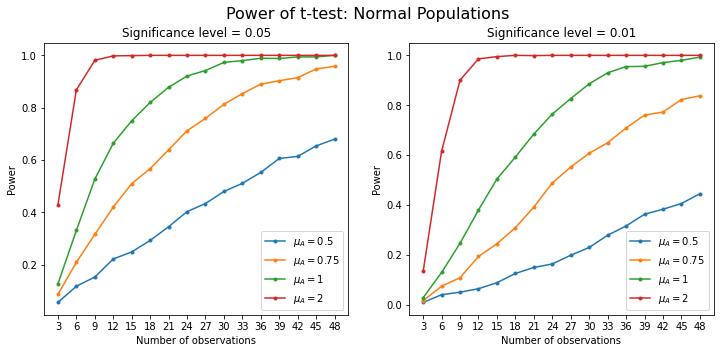

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,5))

ax1.plot(Ns, power1_05, marker='.', label = r'$\mu_A = 0.5$')
ax1.plot(Ns, power1_075, marker='.', label = r'$\mu_A = 0.75$')
ax1.plot(Ns, power1_1, marker='.', label= r'$\mu_A = 1$')
ax1.plot(Ns, power1_2, marker='.', label= r'$\mu_A = 2$')
ax1.set_title('Significance level = 0.05')
ax1.set(xlabel='Number of observations', ylabel='Power')
ax1.set_xticks(Ns) 
ax1.legend(loc = 'lower right')

ax2.plot(Ns, power2_05, marker='.', label=r'$\mu_A = 0.5$')
ax2.plot(Ns, power2_075, marker='.', label = r'$\mu_A = 0.75$')
ax2.plot(Ns, power2_1, marker='.', label=r'$\mu_A = 1$')
ax2.plot(Ns, power2_2, marker='.', label=r'$\mu_A = 2$')
ax2.set_title('Significance level = 0.01')
ax2.set(xlabel='Number of observations', ylabel='Power')
ax2.set_xticks(Ns) 
ax2.legend(loc = 'lower right')

fig.suptitle('Power of t-test: Normal Populations', fontsize=16)
fig.show()
#fig.savefig("fig2_2_powerFemaleFaddiet.png")

## Benchmark

In [14]:
# 1) Basic Features:
B_bench = 150     # Number of Simulations

# Print basic features:
print('Basic Features:')
print('Number of simulations: B =', B_bench)
print('-----------------------------------')
# Significance Levels
sig_grid = np.arange(0, 1.001, 0.001)
#sig_grid = np.arange(0,1.05, 0.05)
print('Shape significance levels:', sig_grid.shape)
print(sig_grid)

model_m50_N20 = Benchmark_Normal_population(m_bench = 50,
                                N_bench = 20,
                                B_bench = B_bench,
                                v_grid = sig_grid,
                                model_CNN =  model_CNN_m50_N20)

Basic Features:
Number of simulations: B = 150
-----------------------------------
Shape significance levels: (1001,)
[0.    0.001 0.002 ... 0.998 0.999 1.   ]


In [15]:
model_m100_N20 = Benchmark_Normal_population(m_bench = 100,
                                N_bench = 20,
                                B_bench = B_bench,
                                v_grid = sig_grid,
                                model_CNN =  model_CNN_m100_N20)

In [16]:
B_bench = 150     # Number of Simulations
model_m150_N20 = Benchmark_Normal_population(m_bench = 150,
                                N_bench = 20,
                                B_bench = B_bench,
                                v_grid = sig_grid,
                                model_CNN =  model_CNN_m150_N20)

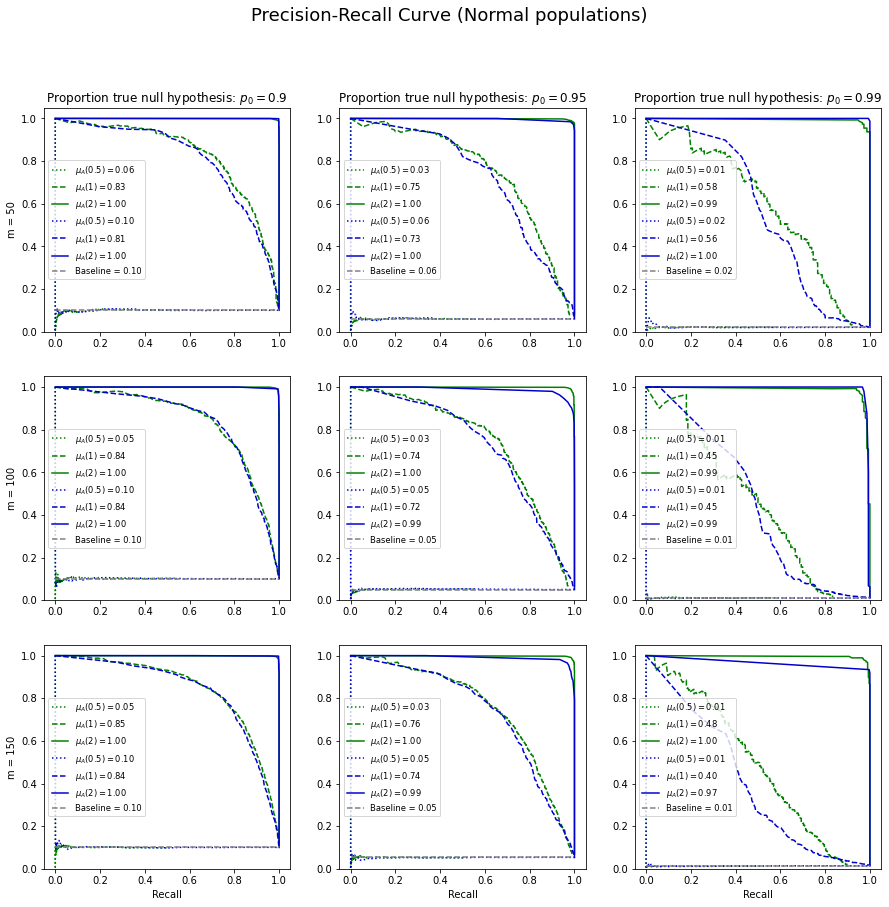

In [17]:
# Plot the benchamark
plot_normal_population_BH_vs_CNN(bench09_I = model_m50_N20['bench09'],
                                 bench095_I= model_m50_N20['bench095'],
                                 bench099_I = model_m50_N20['bench099'],
                                 bench09_II = model_m100_N20['bench09'],
                                 bench095_II = model_m100_N20['bench095'],
                                 bench099_II= model_m100_N20['bench099'],
                                 bench09_III= model_m150_N20['bench09'],
                                 bench095_III= model_m150_N20['bench095'],
                                 bench099_III= model_m150_N20['bench099'],
                                 title = 'Precision-Recall Curve (Normal populations)',
                                fig_save = 'fig4_1_Bench_Normal_pop.png')

In [18]:
from google.colab import files
files.download("fig4_1_Bench_Normal_pop.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>